In [130]:
import os 
os.getcwd()

'/content'

# Autoencoder - code from Kaggle

In [1]:
## load the libraries 
import tensorflow as tf
from keras.layers import Dense, Input, Conv2D, LSTM, MaxPool2D, UpSampling2D
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from numpy import argmax, array_equal
import matplotlib.pyplot as plt
from keras.models import Model
from imgaug import augmenters
from random import randint
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer

In [141]:
# from sklearn.datasets import load_breast_cancer
# dataset = load_breast_cancer()
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/adult.data', header=None)#pd.DataFrame(dataset.data, columns = dataset.feature_names)
train.rename(columns = {0: 'age', 1:'workclass', 2:'fnlwgt', 3:'education', 4:'education-num',
             5:'marital-status', 6:'occupation', 7:'relationship', 8:'race', 9:'sex', 10:'capital-gain', 
             11:'capital-loss', 12:'hours-per-week', 13: 'country', 14: 'target'}, inplace=True)
train.head(3)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,country,target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K


In [ ]:
# train = pd.DataFrame(dataset.target, columns = ['target'])
# np.stack([(train['target']).astype('int')]).T
# # train[list(train.columns)[-2:]].values
# list(train.columns)[:-1]

In [143]:
obj_columns = train.select_dtypes(include = 'object').columns 

In [145]:
from sklearn.preprocessing import LabelEncoder
for cols in obj_columns:
  train[f'scaled_{cols}'] = LabelEncoder().fit_transform(train[cols])
  train.drop(columns = [cols], axis=1, inplace=True)
train.head(3)

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,scaled_workclass,scaled_education,scaled_marital-status,scaled_occupation,scaled_relationship,scaled_race,scaled_sex,scaled_country,scaled_target
0,39,77516,13,2174,0,40,7,9,4,1,1,4,1,39,0
1,50,83311,13,0,0,13,6,9,2,4,0,4,1,39,0
2,38,215646,9,0,0,40,4,11,0,6,1,4,1,39,0


In [146]:
### read dataset 
# dataset = load_breast_cancer()
# data = pd.DataFrame(dataset.data, columns = dataset.feature_names)
# target = pd.DataFrame(dataset.target, columns = ['target'])
# train = pd.concat([data, target], axis=1)
train_x = train[list(train.columns)[:-1]].values
train_y = train['scaled_target'].values #train['target'].values

## normalize and reshape the predictors  
from sklearn.preprocessing import MinMaxScaler
train_x = MinMaxScaler().fit_transform(train_x)

## create train and validation datasets
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2)

## reshape the inputs
train_x = train_x.reshape(-1, train_x.shape[1])
val_x = val_x.reshape(-1, val_x.shape[1])

In [148]:
print(train_x.shape, val_x.shape)
# train_x.reshape(-1, 455)

(26048, 14) (6513, 14)


In [149]:
## input layer
input_layer = Input(shape=(train_x.shape[1],))

## encoding architecture
encode_layer1 = Dense(1500, activation='relu')(input_layer)
encode_layer2 = Dense(1000, activation='relu')(encode_layer1)
encode_layer3 = Dense(500, activation='relu')(encode_layer2)

## latent view
latent_view   = Dense(10, activation='sigmoid')(encode_layer3)

## decoding architecture
decode_layer1 = Dense(500, activation='relu')(latent_view)
decode_layer2 = Dense(1000, activation='relu')(decode_layer1)
decode_layer3 = Dense(1500, activation='relu')(decode_layer2)

## output layer
output_layer  = Dense(train_x.shape[1])(decode_layer3)

model = Model(input_layer, output_layer)

In [150]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 14)]              0         
                                                                 
 dense_26 (Dense)            (None, 1500)              22500     
                                                                 
 dense_27 (Dense)            (None, 1000)              1501000   
                                                                 
 dense_28 (Dense)            (None, 500)               500500    
                                                                 
 dense_29 (Dense)            (None, 10)                5010      
                                                                 
 dense_30 (Dense)            (None, 500)               5500      
                                                                 
 dense_31 (Dense)            (None, 1000)              5010

In [151]:
model.compile(optimizer='adam', loss='mse')
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
model.fit(train_x, train_x, epochs=100, batch_size=2048, validation_data=(val_x, val_x))

Epoch 1/100
13/13 [==============================] - 1s 61ms/step - loss: 0.1009 - val_loss: 0.0609
Epoch 2/100
13/13 [==============================] - 1s 39ms/step - loss: 0.0571 - val_loss: 0.0547
Epoch 3/100
13/13 [==============================] - 1s 41ms/step - loss: 0.0529 - val_loss: 0.0495
Epoch 4/100
13/13 [==============================] - 1s 40ms/step - loss: 0.0405 - val_loss: 0.0339
Epoch 5/100
13/13 [==============================] - 1s 41ms/step - loss: 0.0331 - val_loss: 0.0304
Epoch 6/100
13/13 [==============================] - 1s 39ms/step - loss: 0.0286 - val_loss: 0.0255
Epoch 7/100
13/13 [==============================] - 1s 41ms/step - loss: 0.0241 - val_loss: 0.0217
Epoch 8/100
13/13 [==============================] - 1s 42ms/step - loss: 0.0209 - val_loss: 0.0192
Epoch 9/100
13/13 [==============================] - 1s 41ms/step - loss: 0.0184 - val_loss: 0.0173
Epoch 10/100
13/13 [==============================] - 1s 40ms/step - loss: 0.0156 - val_loss: 0.0132

In [152]:
preds = model.predict(val_x)

In [153]:
preds

array([[ 4.38085586e-01,  1.27181813e-01,  3.89773548e-01, ...,
         9.88884389e-01,  9.93934095e-01,  9.45863008e-01],
       [ 2.75352627e-01,  5.89948259e-02,  7.94443607e-01, ...,
         9.73162591e-01,  1.03602099e+00,  9.95010138e-01],
       [ 1.82216242e-01,  1.21769704e-01,  5.79827309e-01, ...,
         9.94066119e-01,  9.93851960e-01,  9.34274077e-01],
       ...,
       [ 5.35935581e-01,  1.61570519e-01,  5.28138340e-01, ...,
         9.91480649e-01,  9.95620191e-01,  9.42194283e-01],
       [ 7.14653432e-02,  1.91899240e-01,  5.25882721e-01, ...,
         9.89159524e-01,  9.89991963e-01,  9.36598301e-01],
       [ 1.54660478e-01,  7.30105564e-02,  8.60780954e-01, ...,
         9.97907698e-01, -6.82697631e-04,  9.47515428e-01]], dtype=float32)

In [154]:
val_x

array([[0.45205479, 0.12566863, 0.4       , ..., 1.        , 1.        ,
        0.95121951],
       [0.31506849, 0.00863884, 0.8       , ..., 1.        , 1.        ,
        0.95121951],
       [0.20547945, 0.13159696, 0.6       , ..., 1.        , 1.        ,
        0.95121951],
       ...,
       [0.54794521, 0.16480624, 0.53333333, ..., 1.        , 1.        ,
        0.95121951],
       [0.08219178, 0.18998519, 0.53333333, ..., 1.        , 1.        ,
        0.95121951],
       [0.17808219, 0.0811528 , 0.86666667, ..., 1.        , 0.        ,
        0.95121951]])

In [156]:
pred_df = pd.DataFrame(preds, columns = train.columns[:-1])#dataset.feature_names)
real_df = pd.DataFrame(val_x, columns = train.columns[:-1])#dataset.feature_names)

In [157]:
pred_df.mean(axis=0) 

age                      0.280318
fnlwgt                   0.118425
education-num            0.600647
capital-gain             0.019316
capital-loss             0.019823
hours-per-week           0.416917
scaled_workclass         0.485622
scaled_education         0.673032
scaled_marital-status    0.439414
scaled_occupation        0.469141
scaled_relationship      0.301047
scaled_race              0.907569
scaled_sex               0.663734
scaled_country           0.889169
dtype: float32

In [ ]:
pred_df.apply(lambda x: 0 if x.mean(axis=0) < 0.5 else 1)

In [158]:
diff = np.abs(pred_df - real_df)#.mean().sort_values(ascending=False)
diff

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,scaled_workclass,scaled_education,scaled_marital-status,scaled_occupation,scaled_relationship,scaled_race,scaled_sex,scaled_country
0,0.013969,0.001513,0.010226,0.007067,0.000196,0.015172,0.003122,0.016400,0.005460,0.014807,0.003375,0.011116,0.006066,0.005357
1,0.039716,0.050356,0.005556,0.047084,0.001259,0.039985,0.024058,0.022058,0.006262,0.020224,0.021505,0.026837,0.036021,0.043791
2,0.023263,0.009827,0.020173,0.001306,0.019376,0.024824,0.017165,0.010465,0.004709,0.001868,0.004999,0.005934,0.006148,0.016945
3,0.010580,0.005497,0.006889,0.015002,0.003952,0.009291,0.001122,0.018200,0.002938,0.004075,0.007843,0.012220,0.010356,0.011118
4,0.027706,0.105852,0.000869,0.024506,0.000169,0.018589,0.021580,0.006697,0.005066,0.002462,0.006855,0.002165,0.017073,0.020099
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6508,0.008973,0.002905,0.000561,0.007929,0.000906,0.010842,0.005994,0.019227,0.003986,0.002439,0.007998,0.015140,0.009451,0.007146
6509,0.023824,0.061675,0.015971,0.033905,0.001968,0.011758,0.012845,0.007747,0.011528,0.006812,0.001224,0.018603,0.005840,0.016113
6510,0.012010,0.003236,0.005195,0.014931,0.002944,0.014646,0.006925,0.012031,0.002229,0.006990,0.008835,0.008519,0.004380,0.009025
6511,0.010726,0.001914,0.007451,0.000681,0.000675,0.015298,0.003511,0.013292,0.007223,0.008822,0.008623,0.010840,0.010008,0.014621


In [69]:
diff.index

Index(['mean symmetry', 'mean smoothness', 'worst symmetry',
       'worst smoothness', 'texture error', 'mean texture', 'symmetry error',
       'smoothness error', 'worst concave points', 'worst concavity',
       'mean fractal dimension', 'worst texture', 'mean radius',
       'worst fractal dimension', 'mean concave points',
       'concave points error', 'mean perimeter', 'worst compactness',
       'worst radius', 'compactness error', 'mean area', 'mean compactness',
       'worst perimeter', 'mean concavity', 'radius error', 'perimeter error',
       'fractal dimension error', 'worst area', 'concavity error',
       'area error'],
      dtype='object')

In [70]:
diff.values

array([0.07873118, 0.07225891, 0.06645578, 0.06410291, 0.05870668,
       0.05812978, 0.05464462, 0.05358624, 0.05157702, 0.04829376,
       0.04788455, 0.04678045, 0.04634119, 0.04447428, 0.04361532,
       0.04327112, 0.04230837, 0.03957049, 0.03550183, 0.03311614,
       0.03268454, 0.03186444, 0.03175171, 0.03153127, 0.02985189,
       0.02708034, 0.02529559, 0.02435822, 0.02326342, 0.01700672])

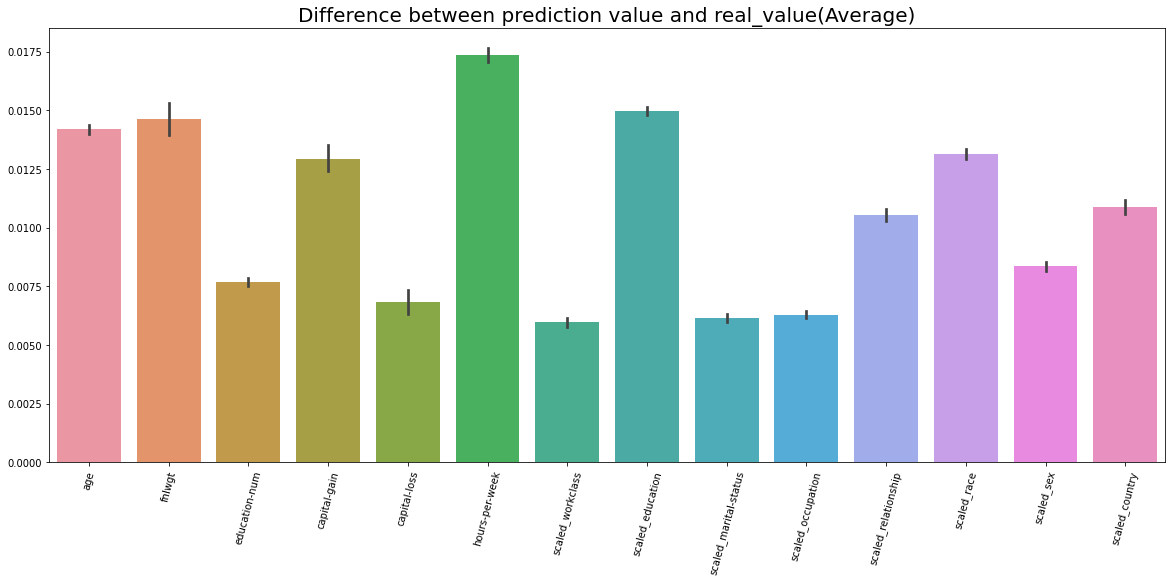

In [159]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.figure(figsize = (20, 8))
sns.barplot(data=diff)
plt.xticks(rotation=75)
plt.title('Difference between prediction value and real_value(Average)', fontsize = 20)
plt.show()

In [83]:
diff.mean()

mean radius                0.046341
mean texture               0.058130
mean perimeter             0.042308
mean area                  0.032685
mean smoothness            0.072259
mean compactness           0.031864
mean concavity             0.031531
mean concave points        0.043615
mean symmetry              0.078731
mean fractal dimension     0.047885
radius error               0.029852
texture error              0.058707
perimeter error            0.027080
area error                 0.017007
smoothness error           0.053586
compactness error          0.033116
concavity error            0.023263
concave points error       0.043271
symmetry error             0.054645
fractal dimension error    0.025296
worst radius               0.035502
worst texture              0.046780
worst perimeter            0.031752
worst area                 0.024358
worst smoothness           0.064103
worst compactness          0.039570
worst concavity            0.048294
worst concave points       0

## Autoencoder (LSTM) - code from https://velog.io/@jaehyeong/LSTM-Autoencoder-for-Anomaly-Detection

In [160]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
from collections import Counter
import tensorflow as tf
from tensorflow.keras import Model ,models, layers, optimizers, regularizers
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [161]:
train.head(3)

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,scaled_workclass,scaled_education,scaled_marital-status,scaled_occupation,scaled_relationship,scaled_race,scaled_sex,scaled_country,scaled_target
0,39,77516,13,2174,0,40,7,9,4,1,1,4,1,39,0
1,50,83311,13,0,0,13,6,9,2,4,0,4,1,39,0
2,38,215646,9,0,0,40,4,11,0,6,1,4,1,39,0


In [165]:
sign = lambda x: (1, -1)[x < 0]
def curve_shift(df, shift_by):
	vector = df['scaled_target'].copy()
	for s in range(abs(shift_by)):
		tmp = vector.shift(sign(shift_by))
		tmp = tmp.fillna(0)
		vector += tmp
	labelcol = 'scaled_target'
	# Add vector to the df
	df.insert(loc=0, column=labelcol+'tmp', value=vector)

	# Remove the rows with labelcol == 1.
	df = df.drop(df[df[labelcol] == 1].index)

	# Drop labelcol and rename the tmp col as labelcol
	df = df.drop(labelcol, axis=1)
	df = df.rename(columns={labelcol+'tmp': labelcol})

	# Make the labelcol binary
	df.loc[df[labelcol] > 0, labelcol] = 1

	return df

In [166]:
shifted_df = curve_shift(train, shift_by=-5)
shifted_df.head()

,scaled_target,targettmp,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,scaled_workclass,scaled_education,scaled_marital-status,scaled_occupation,scaled_relationship,scaled_race,scaled_sex,scaled_country
0,0.0,0.0,39,77516,13,2174,0,40,7,9,4,1,1,4,1,39
1,0.0,0.0,50,83311,13,0,0,13,6,9,2,4,0,4,1,39
2,1.0,1.0,38,215646,9,0,0,40,4,11,0,6,1,4,1,39
3,1.0,6.0,53,234721,7,0,0,40,4,1,2,6,0,2,1,39
4,1.0,16.0,28,338409,13,0,0,40,4,9,2,10,5,2,0,5


In [168]:
# x, y
input_x = shifted_df.drop('scaled_target', axis=1).values
input_y = shifted_df['scaled_target'].values
n_features = input_x.shape[1]

In [169]:
input_x

array([[0.00000e+00, 3.90000e+01, 7.75160e+04, ..., 4.00000e+00,
        1.00000e+00, 3.90000e+01],
       [0.00000e+00, 5.00000e+01, 8.33110e+04, ..., 4.00000e+00,
        1.00000e+00, 3.90000e+01],
       [1.00000e+00, 3.80000e+01, 2.15646e+05, ..., 4.00000e+00,
        1.00000e+00, 3.90000e+01],
       ...,
       [1.00000e+01, 2.70000e+01, 2.57302e+05, ..., 4.00000e+00,
        0.00000e+00, 3.90000e+01],
       [1.00000e+01, 5.80000e+01, 1.51910e+05, ..., 4.00000e+00,
        0.00000e+00, 3.90000e+01],
       [5.00000e+00, 2.20000e+01, 2.01490e+05, ..., 4.00000e+00,
        1.00000e+00, 3.90000e+01]])

In [170]:
input_y

array([0., 0., 1., ..., 1., 1., 1.])

In [171]:
n_features

15

In [172]:
def temporalize(X, y, timesteps):
	output_X = []
	output_y = []
	for i in range(len(X) - timesteps - 1):
		t = []
		for j in range(1, timesteps + 1):
			# Gather the past records upto the lookback period
			t.append(X[[(i + j + 1)], :])
		output_X.append(t)
		output_y.append(y[i + timesteps + 1])
	return np.squeeze(np.array(output_X)), np.array(output_y)
timesteps = 5

# Temporalize
x, y = temporalize(input_x, input_y, timesteps)
print(x.shape)

(24714, 5, 15)


In [173]:
# Split into train, valid, and test 
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2)

print(len(x_train))
print(len(x_valid))  
print(len(x_test))

15816
3955
4943


In [174]:
# For training the autoencoder, split 0 / 1
x_train_y0 = x_train[y_train == 0]
x_train_y1 = x_train[y_train == 1]

x_valid_y0 = x_valid[y_valid == 0]
x_valid_y1 = x_valid[y_valid == 1]

In [175]:
def flatten(X):
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)

def scale(X, scaler):
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])
        
    return X

In [176]:
# from sklearn.preprocessing import StandardScaler
scaler = MinMaxScaler().fit(flatten(x_train_y0))
x_train_y0_scaled = scale(x_train_y0, scaler)
x_valid_scaled = scale(x_valid, scaler)
x_valid_y0_scaled = scale(x_valid_y0, scaler)
x_test_scaled = scale(x_test, scaler)

In [185]:
epochs = 200
batch = 150
lr = 0.001
lstm_ae = models.Sequential()

# Encoder
lstm_ae.add(layers.LSTM(32, activation='relu', input_shape=(timesteps, n_features), return_sequences=True))
lstm_ae.add(layers.LSTM(16, activation='relu', return_sequences=False))
lstm_ae.add(layers.RepeatVector(timesteps))
# Decoder
lstm_ae.add(layers.LSTM(16, activation='relu', return_sequences=True))
lstm_ae.add(layers.LSTM(32, activation='relu', return_sequences=True))
lstm_ae.add(layers.TimeDistributed(layers.Dense(n_features)))

lstm_ae.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 5, 32)             6144      
                                                                 
 lstm_13 (LSTM)              (None, 16)                3136      
                                                                 
 repeat_vector_3 (RepeatVect  (None, 5, 16)            0         
 or)                                                             
                                                                 
 lstm_14 (LSTM)              (None, 5, 16)             2112      
                                                                 
 lstm_15 (LSTM)              (None, 5, 32)             6272      
                                                                 
 time_distributed_3 (TimeDis  (None, 5, 15)            495       
 tributed)                                            

In [186]:
# compile
lstm_ae.compile(loss='mse', optimizer=optimizers.Adam(lr))

# fit
history = lstm_ae.fit(x_train_y0_scaled, x_train_y0_scaled,
                     epochs=epochs, batch_size=batch,
                     validation_data=(x_valid_y0_scaled, x_valid_y0_scaled))

Epoch 1/200
27/27 [==============================] - 9s 119ms/step - loss: 4.1205 - val_loss: 3.7940
Epoch 2/200
27/27 [==============================] - 2s 86ms/step - loss: 3.2319 - val_loss: 2.0957
Epoch 3/200
27/27 [==============================] - 2s 88ms/step - loss: 1.4005 - val_loss: 0.7806
Epoch 4/200
27/27 [==============================] - 2s 87ms/step - loss: 0.5124 - val_loss: 0.3242
Epoch 5/200
27/27 [==============================] - 2s 86ms/step - loss: 0.2586 - val_loss: 0.2117
Epoch 6/200
27/27 [==============================] - 2s 91ms/step - loss: 0.1881 - val_loss: 0.1684
Epoch 7/200
27/27 [==============================] - 2s 86ms/step - loss: 0.1565 - val_loss: 0.1438
Epoch 8/200
27/27 [==============================] - 2s 85ms/step - loss: 0.1380 - val_loss: 0.1287
Epoch 9/200
27/27 [==============================] - 2s 86ms/step - loss: 0.1233 - val_loss: 0.1171
Epoch 10/200
27/27 [==============================] - 2s 87ms/step - loss: 0.1104 - val_loss: 0.106

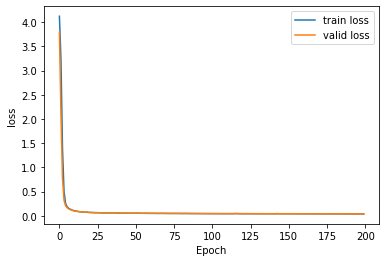

In [187]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='valid loss')
plt.legend()
plt.xlabel('Epoch'); plt.ylabel('loss')
plt.show()

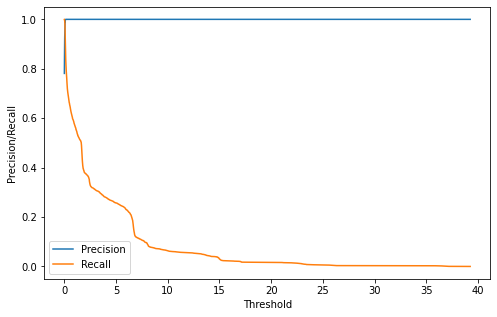

In [188]:
valid_x_predictions = lstm_ae.predict(x_valid_scaled)
mse = np.mean(np.power(flatten(x_valid_scaled) - flatten(valid_x_predictions), 2), axis=1)

error_df = pd.DataFrame({'Reconstruction_error':mse, 
                         'True_class':list(y_valid)})
precision_rt, recall_rt, threshold_rt = metrics.precision_recall_curve(error_df['True_class'], error_df['Reconstruction_error'])

plt.figure(figsize=(8,5))
plt.plot(threshold_rt, precision_rt[1:], label='Precision')
plt.plot(threshold_rt, recall_rt[1:], label='Recall')
plt.xlabel('Threshold'); plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

In [189]:
# best position of threshold
index_cnt = [cnt for cnt, (p, r) in enumerate(zip(precision_rt, recall_rt)) if p==r][0]
print('precision: ',precision_rt[index_cnt],', recall: ',recall_rt[index_cnt])

# fixed Threshold
threshold_fixed = threshold_rt[index_cnt]
print('threshold: ',threshold_fixed)

precision:  0.9789115646258504 , recall:  0.9789115646258504
threshold:  0.07406536673824353


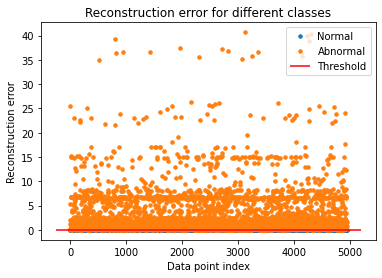

In [190]:
test_x_predictions = lstm_ae.predict(x_test_scaled)
mse = np.mean(np.power(flatten(x_test_scaled) - flatten(test_x_predictions), 2), axis=1)

error_df = pd.DataFrame({'Reconstruction_error': mse,
                         'True_class': y_test.tolist()})

groups = error_df.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Abnormal" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();


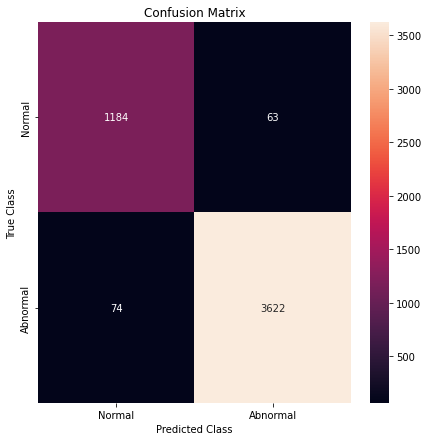

In [191]:
# classification by threshold
LABELS = ['Normal', 'Abnormal']
pred_y = [1 if e > threshold_fixed else 0 for e in error_df['Reconstruction_error'].values]

conf_matrix = metrics.confusion_matrix(error_df['True_class'], pred_y)
plt.figure(figsize=(7, 7))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class'); plt.ylabel('True Class')
plt.show()

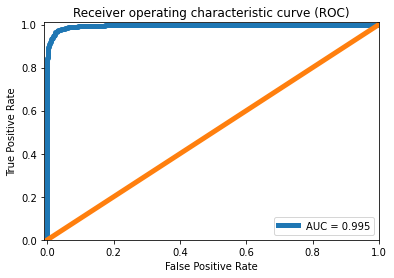

In [192]:
false_pos_rate, true_pos_rate, thresholds = metrics.roc_curve(error_df['True_class'], error_df['Reconstruction_error'])
roc_auc = metrics.auc(false_pos_rate, true_pos_rate,)

plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate'); plt.xlabel('False Positive Rate')
plt.show()